# Image Processing using the SSBD-OMERO API

In [9]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# HTTP library
import requests

# Stream of in-memory bytes
from io import BytesIO
# Pillow library
from PIL import Image
# OpenCV library
import cv2

print (cv2.__version__)
# tested Python 2 or 3 + OpenCV v 3.2.0

3.2.0


# 1. Check a HTTP session to SSBD using the requests library

In [10]:
SSBD_BASE_URL = "http://ssbd.qbic.riken.jp/image"

url = SSBD_BASE_URL
if requests.session().get(url).status_code == 200:
    print("Successfully connected to OMERO")
else:
    print("Failed to connect to OMERO")
print(url)

Successfully connected to OMERO
http://ssbd.qbic.riken.jp/image


# 2. Get image 

http://ssbd.qbic.riken.jp/image/webgateway/render_image/36874/0/100/


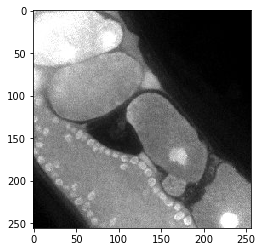

In [11]:
# Sample in Takayama imagesets
IMAGE_ID = 36874 
Z = 0
T = 100

# Sample in Kyoda imagesets
#IMAGE_ID = 1
#Z = 20
#T = 0

TMP_URL = "{base}/webgateway/render_image/{image_id}/{z}/{t}/"
qs = {'base': SSBD_BASE_URL, 'image_id': IMAGE_ID, 'z': Z, 't': T}
url = TMP_URL.format(**qs)

r = requests.session().get(url)
if r.status_code != 200:
    print("access error (1)")
    sys.exit()

# PIL (RGB) -> OpenCV (Grayscale)
cv_img1 = cv2.cvtColor(np.array(Image.open(BytesIO(r.content))), cv2.COLOR_RGB2GRAY)
plt.imshow(cv_img1, 'gray')

print(url)

# 3. Check image metadata

In [12]:
TMP_URL = "{base}/webclient/imgData/{image_id}/"
qs = {'base': SSBD_BASE_URL, 'image_id': IMAGE_ID}
url = TMP_URL.format(**qs)

r = requests.session().get(url)
if r.status_code != 200:
    print("access error")
    sys.exit()

metadata = r.json()

print (url)
print ("ProjectName:", metadata['meta']['projectName'])
print ("Dataset:", metadata['meta']['datasetName'])
print ("X:", metadata['size']['width'])
print ("Y:", metadata['size']['height'])
print ("Z:", metadata['size']['z'])
print ("T:", metadata['size']['t'])
print ("C:", metadata['size']['c'])
print ("PixelsType: ", metadata['meta']['pixelsType'])
print ("PixwlRange: ", metadata['pixel_range'][1])

print ("\n", metadata)

http://ssbd.qbic.riken.jp/image/webclient/imgData/36874/
ProjectName: 12-Takayama-Oocyte
Dataset: Fig1D_DMRE_110120-1
X: 256
Y: 256
Z: 1
T: 1350
C: 1
PixelsType:  uint8
PixwlRange:  255

 {'init_zoom': 0, 'tiles': False, 'perms': {'canAnnotate': False, 'canEdit': False, 'canDelete': False, 'canLink': False}, 'rdefs': {'defaultT': 0, 'model': 'greyscale', 'invertAxis': False, 'projection': 'normal', 'defaultZ': 0}, 'pixel_range': [0, 255], 'interpolate': True, 'channels': [{'color': '808080', 'emissionWave': None, 'label': '0', 'window': {'max': 255.0, 'end': 255.0, 'start': 0.0, 'min': 0.0}, 'active': True, 'reverseIntensity': False}], 'meta': {'projectName': '12-Takayama-Oocyte', 'imageId': 36874, 'imageAuthor': 'public data', 'imageTimestamp': 1479133224.0, 'pixelsType': 'uint8', 'datasetId': 217, 'projectDescription': 'See details in Takayama and Onami. (2016) Cell Reports, 15(3), 625-637', 'datasetName': 'Fig1D_DMRE_110120-1', 'wellSampleId': '', 'projectId': 11, 'imageDescription'

# 4. Get image ROI

http://ssbd.qbic.riken.jp/image/webgateway/render_image_region/36874/0/100/?region=100,100,100,100


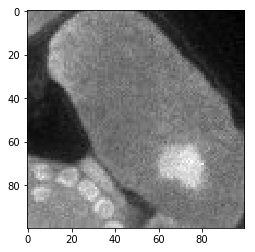

In [13]:
startX = 0
startY = 0
sizeX  = 100
sizeY  = 100
if IMAGE_ID == 36874:
    startX = 100
    startY = 100
    sizeX  = 100
    sizeY  = 100
elif IMAGE_ID == 1:
    startX = 100
    startY = 300
    sizeX  = 200
    sizeY  = 200

TMP_URL = "{base}/webgateway/render_image_region/{image_id}/{z}/{t}/?region={startX},{startY},{sizeX},{sizeY}"
qs = {'base': SSBD_BASE_URL, 'image_id': IMAGE_ID, 'z': Z, 't': T, 'startX': startX, 'startY': startY, 'sizeX': sizeX, 'sizeY': sizeY}
url = TMP_URL.format(**qs)
r = requests.session().get(url)

print(url)
cv_img1_roi = cv2.cvtColor(np.array(Image.open(BytesIO(r.content))), cv2.COLOR_RGB2GRAY)
plt.imshow(cv_img1_roi, 'gray')


# 5. Binalize image using its metadata

maxPixel= 255 thresh= 86.0


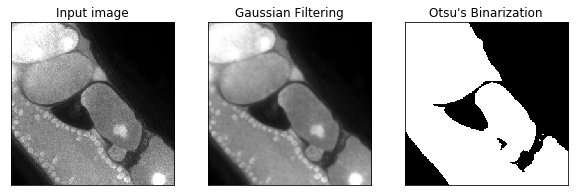

In [14]:
# Filterd
cv_img2 = cv2.GaussianBlur(cv_img1, (5,5), 0)

maxPixel = int(metadata['pixel_range'][1])
ret, cv_img3 = cv2.threshold(cv_img2, 0, maxPixel, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print ("maxPixel=", maxPixel, "thresh=", ret)
# thresh = ??
#ret, cv_img3 = cv2.threshold(cv_img2, thresh, maxPixel, cv2.THRESH_BINARY)

titles = ['Input image', "Gaussian Filtering", "Otsu's Binarization"]
images = [cv_img1, cv_img2, cv_img3]

plt.figure(figsize=(10,3))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.savefig('result1.tiff')

#  6. Extract contours

#contours= 5 , #hierarchy= 1
max_i= 4 max_area= 39409.5
[[ 0.  0.]
 [ 0.  1.]
 [ 0.  2.]
 ..., 
 [ 3.  0.]
 [ 2.  0.]
 [ 1.  0.]]


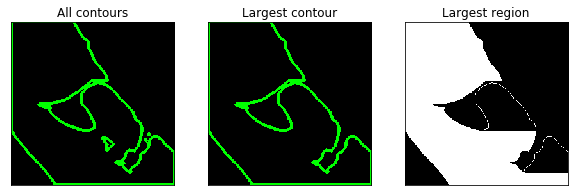

In [15]:
ret,contours,hierarchy = cv2.findContours(cv_img3, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print("#contours=",len(contours), ", #hierarchy=", len(hierarchy))

max_i = None
max_area = None
for i in range(0, len(contours)):
    area = cv2.contourArea(contours[i])
    #print(i, area)
    if max_area == None or area > max_area:
        max_area = area
        max_i = i

print ("max_i=", max_i, "max_area=", max_area)

size = metadata['size']['height'], metadata['size']['width'], 3
#print (size)

black_img = np.zeros(size, dtype=np.uint8)
img0 = cv2.drawContours(black_img, contours, -1, (0,255,0), 3)

black_img = np.zeros(size, dtype=np.uint8)
img1 = cv2.drawContours(black_img, contours[max_i], -1, (0,255,0), 3)

black_img = np.zeros(size, dtype=np.uint8)
img2 = cv2.fillConvexPoly(black_img, contours[max_i], (255,255,255))

vec = np.array(contours[max_i], dtype=np.float).reshape((contours[i].shape[0], contours[i].shape[2]))
print(vec)

titles = ['All contours', 'Largest contour', "Largest region"]
images = [img0, img1, img2]

plt.figure(figsize=(10,3))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.savefig('result2.tiff')

In [16]:
mean, eigenvectors = cv2.PCACompute(vec, mean=np.array([], dtype=np.float), maxComponents=1)
pt = (mean[0][0], mean[0][1])
vec = (eigenvectors[0][0], eigenvectors[0][1])
print (pt, vec)

(115.81912350597609, 147.12430278884463) (0.67771250571166208, 0.73532697461878849)
